In [1]:
# imports:  
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0);

# Data normalization

In [2]:
# Create fake data

# Input: 100 data points, 1 feature
x_train = torch.rand(100,1)
x_test = torch.linspace(start=0.,end=1.,steps=100).unsqueeze(-1)

# Output: 100 data points, 2 feature
pi = np.pi
factor = 100.
y_train = torch.cat((torch.sin(2*pi*x_train), factor*torch.cos(2*pi*x_train)), dim=1)
y_test = torch.cat((torch.sin(2*pi*x_test), factor*torch.cos(2*pi*x_test)), dim=1)

## Visualize your data!

In [3]:
# Check x-data shape
x_train.shape

torch.Size([100, 1])

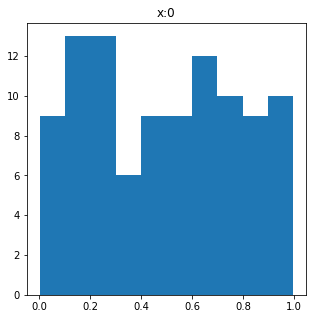

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.hist(x_train[:,0].detach().numpy())
axes.set_title('x:0');

In [5]:
# Check y-data shape
y_train.shape

torch.Size([100, 2])

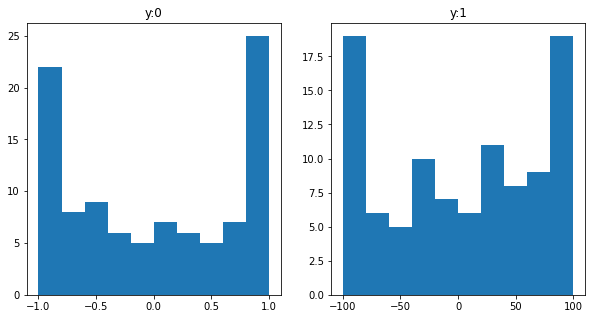

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(y_train[:,0].detach().numpy())
axes[0].set_title('y:0');
axes[1].hist(y_train[:,1].detach().numpy())
axes[1].set_title('y:1');

### Notice the range of data!!
---

## Normalize your data


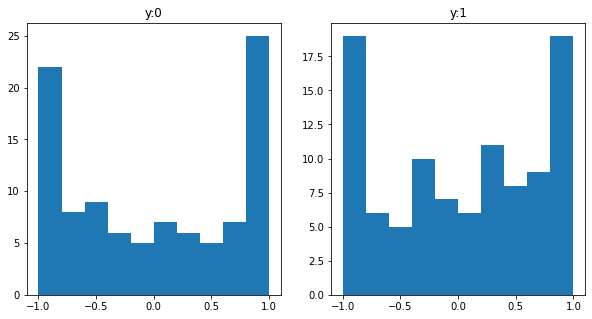

In [8]:
# To-do
class Normalization:
    def __init__(self,data):
        
        # empty list of min and max values of each column
        self.min_values = []
        self.max_values = []
        
        # find min and max of each column and store in lists
        for i in range(data.shape[1]):
            self.min_values.append(torch.min(data[:,i]))
            self.max_values.append(torch.max(data[:,i]))
        
    def normalize(self, data):
        
        # clone the data before modification
        normalized_data = data.clone()
        
        #iterate over all columns
        for i in range(0, data.shape[1]):
            
            # z = a+b*z', where z' in [-1,1] is normalized data
            # min_z = a-b, when z'=-1
            # max_z = a+b, when z'=1
            # normalize each column between values 0 and 1 range
            a = (self.max_values[i]+self.min_values[i])/2.
            b = (self.max_values[i]-self.min_values[i])/2.
            normalized_data[:,i] = (data[:,i]-a)/b
        
        # return
        return normalized_data
    
    def unnormalize(self, data):
        
        # clone the data before modification
        unnormalized_data = data.clone()
        
        #iterate over all columns
        for i in range(0, data.shape[1]):            
            
            # z = a+b*z', where z' in [-1,1] is normalized data
            # min_z = a-b, when z'=-1
            # max_z = a+b, when z'=1
            # unnormalize each column to original range
            a = (self.max_values[i]+self.min_values[i])/2.
            b = (self.max_values[i]-self.min_values[i])/2.
            unnormalized_data[:,i] = a + b*data[:,i]          
            
        # return
        return unnormalized_data
    
# Always use TRAINING DATA ONLY for identifying min and max values for normalization
y_normalization = Normalization(y_train)

# Normalize both training and test data
y_train = y_normalization.normalize(y_train)
y_test = y_normalization.normalize(y_test)

# Visualize the normalized data
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(y_train[:,0].detach().numpy())
axes[0].set_title('y:0');
axes[1].hist(y_train[:,1].detach().numpy())
axes[1].set_title('y:1');



In [9]:
# Create a NN model to fit the data
nn = torch.nn.Sequential(
    torch.nn.Linear(1,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,2)
)

# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.01

# Optimizer: use Adam
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = torch.nn.MSELoss()

# Number of epochs
num_epochs = 1000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = nn(x_train)
    
    # Compute the loss. 
    train_loss = loss_function(y_train_pred, y_train)
    
    
    # store the loss in a list
    train_loss_history.append(train_loss.detach().item())
    
    
    # Call .backward() on loss to compute gradient (d_loss/d_a)
    train_loss.backward()
    
    # Update the model paramaeters
    # No need for torch.no_grad() anymore with in-built optimizers
    optimizer.step()
    
    # remove any pre-exisitng gradients stored
    optimizer.zero_grad()
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad(): #torch.no_grad() is back because we don't train on test data and so don't need gradients
        
        # Make your predictions
        y_test_pred = nn(x_test)
        
        # Compute the loss.
        test_loss = loss_function(y_test_pred, y_test)
        
        
        # store the loss in a list
        test_loss_history.append(test_loss.detach().item())

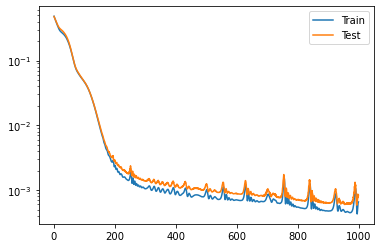

In [10]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test'])

In [11]:
def calculate_R2(true, pred):
    # Note: both true and pred should be numpy 1D-array, NOT torch tensors
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)


def plotR2(true, pred):
    dim = true.shape[1]
    fig = plt.figure(figsize=plt.figaspect(1./dim))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([true[:,index].min(),true[:,index].max()],[true[:,index].min(),true[:,index].max()],c='red')
        ax.set_title('Label dim: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(dim):
        ax = fig.add_subplot(1, dim, i+1); helper(ax,i)
    fig.tight_layout()

In [12]:
with torch.no_grad():
    # Make prediction on test set
    y_test_pred = nn(x_test)

In [13]:
# Unnormalize all y-data
# To-do
y_train = y_normalization.unnormalize(y_train)
y_test = y_normalization.unnormalize(y_test)
y_test_pred = y_normalization.unnormalize(y_test_pred)

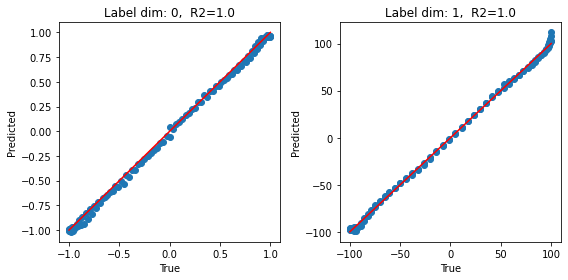

In [14]:
# Visualize accuracy
plotR2(y_test, y_test_pred)

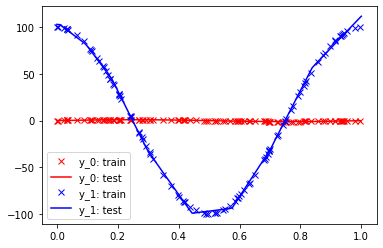

In [15]:
plt.plot(x_train,y_train[:,0],linestyle='None',color='r',marker='x')
plt.plot(x_test,y_test_pred[:,0].detach().squeeze(),color='r')

plt.plot(x_train,y_train[:,1],linestyle='None',color='b',marker='x')
plt.plot(x_test,y_test_pred[:,1].detach().squeeze(),color='b')

plt.legend(['y_0: train','y_0: test','y_1: train','y_1: test'])

# Now turn off the normalization and re-run the notebook!
(You can comment out the normalization and unnormalization for-loops in the Normalization class definition.)

# What happens? Did the results degrade? Why?

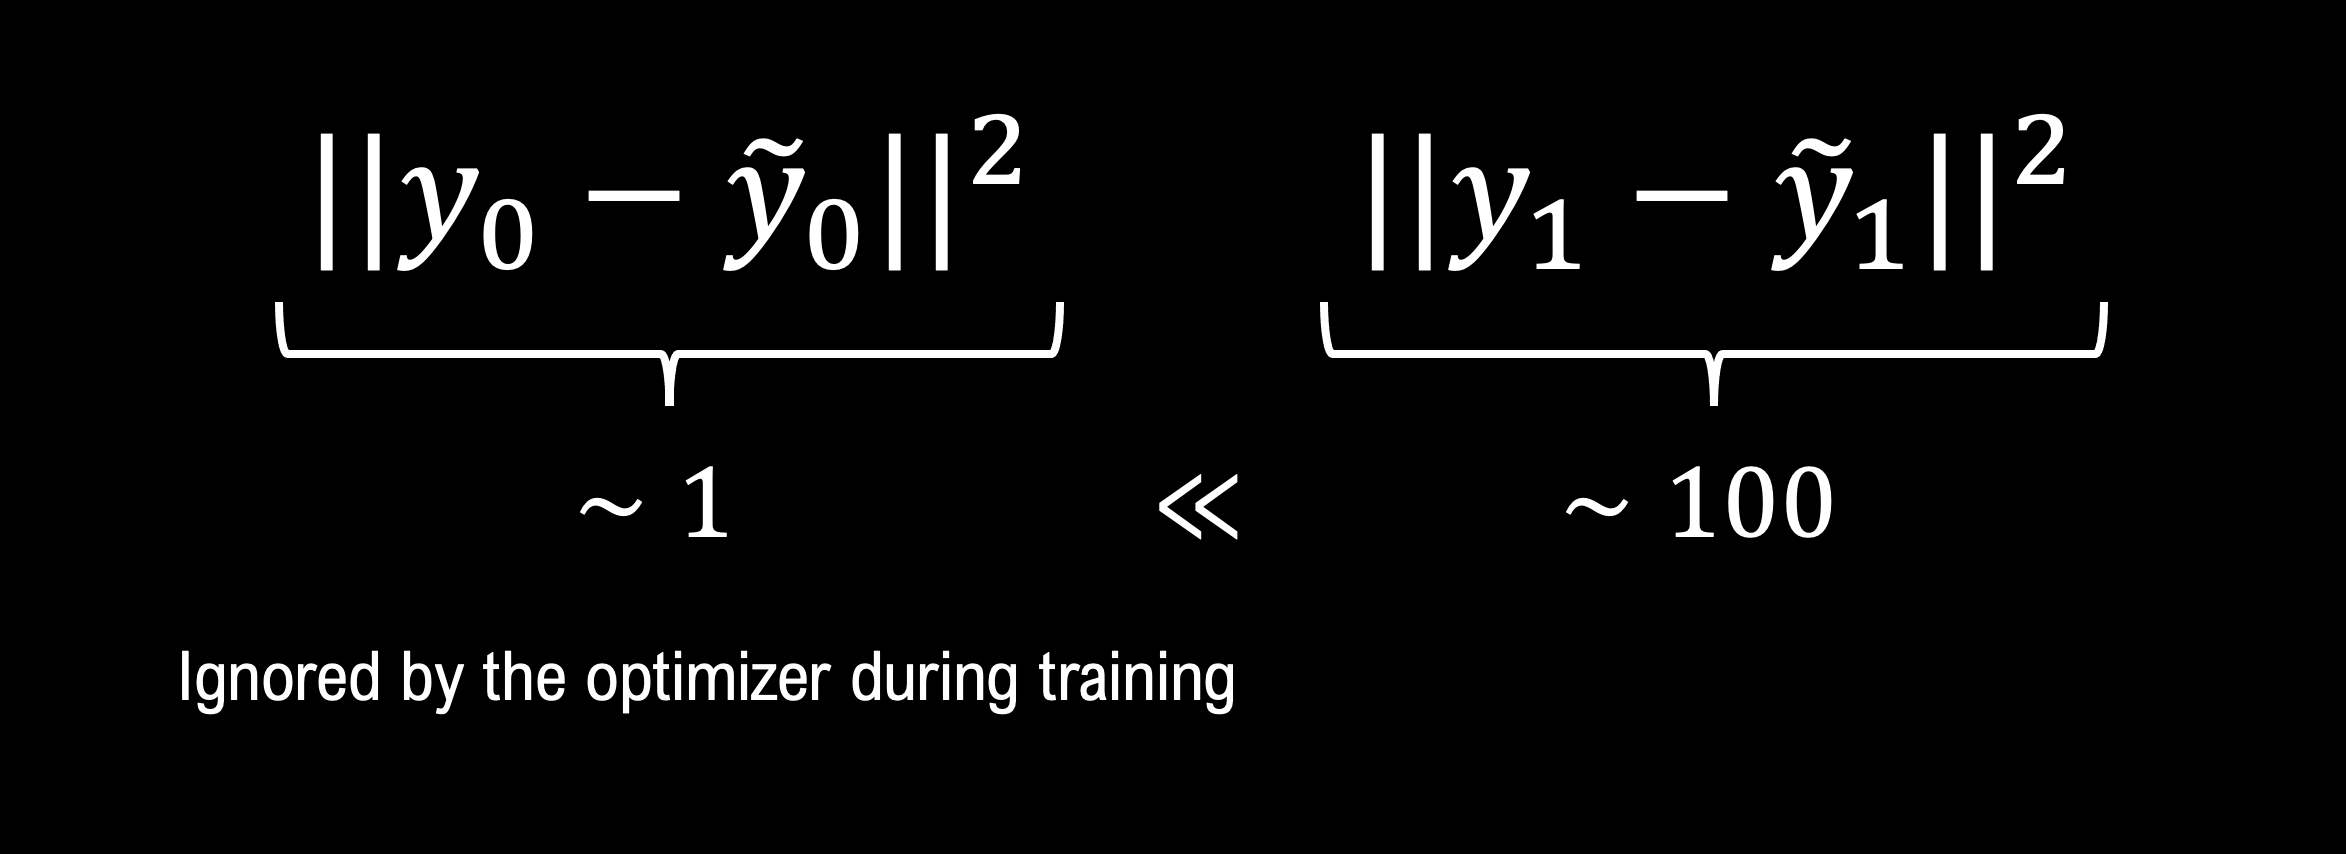